## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets

%matplotlib inline

## The dataset
This function creates a dataset with two classes in two dimensions. It has two parameters: the size of the dataset and the spread of each one of the classes. A high spread value makes both classes to superpose, making the classification more difficult.

In [2]:
def create_dataset(n, s):
    n1 = int(np.ceil(n / 2.0))
    n2 = int(np.floor(n / 2.0))
    x1 = np.random.normal(-1, s, n1)
    y1 = np.random.uniform(-1, 1,  n1)
    x2 = np.random.normal(1, s, n2)
    y2 = np.random.uniform(-1, 1, n2)
    return np.stack((np.concatenate((x1, x2)), np.concatenate((y1, y2)), np.concatenate((np.ones(n1), -1*np.ones(n2)))), 1)

In [3]:
def plot_dataset(s):
    dataset = create_dataset(200, s)
    pl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[cl > 0] for cl in dataset[:,2]])
    pl.xlim(-3,3)
    pl.ylim(-1,1)
    pl.grid()

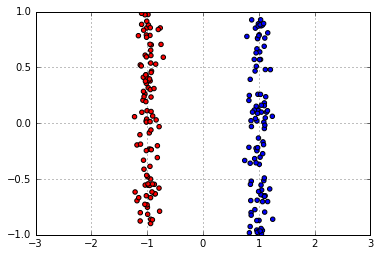

In [4]:
interact(plot_dataset, s=widgets.FloatSlider(value=0.1, min=0.1, max=1.0, step=0.01, description='Spread:',));

## The MLP

In [5]:
import mlp_backprop_momentum as mlp
reload(mlp)

<module 'mlp_backprop_momentum' from 'mlp_backprop_momentum.pyc'>

## Cross-validation

In [6]:
import k_fold_cross_validation as cv
reload(cv)

<module 'k_fold_cross_validation' from 'k_fold_cross_validation.pyc'>

## Dataset

In [7]:
DATASET_SIZE = 200
SPREAD = 0.6
dataset = create_dataset(DATASET_SIZE, SPREAD)

## Exploring the number of epochs

In [8]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [9]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([2,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:2], dataset[:,2:4]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


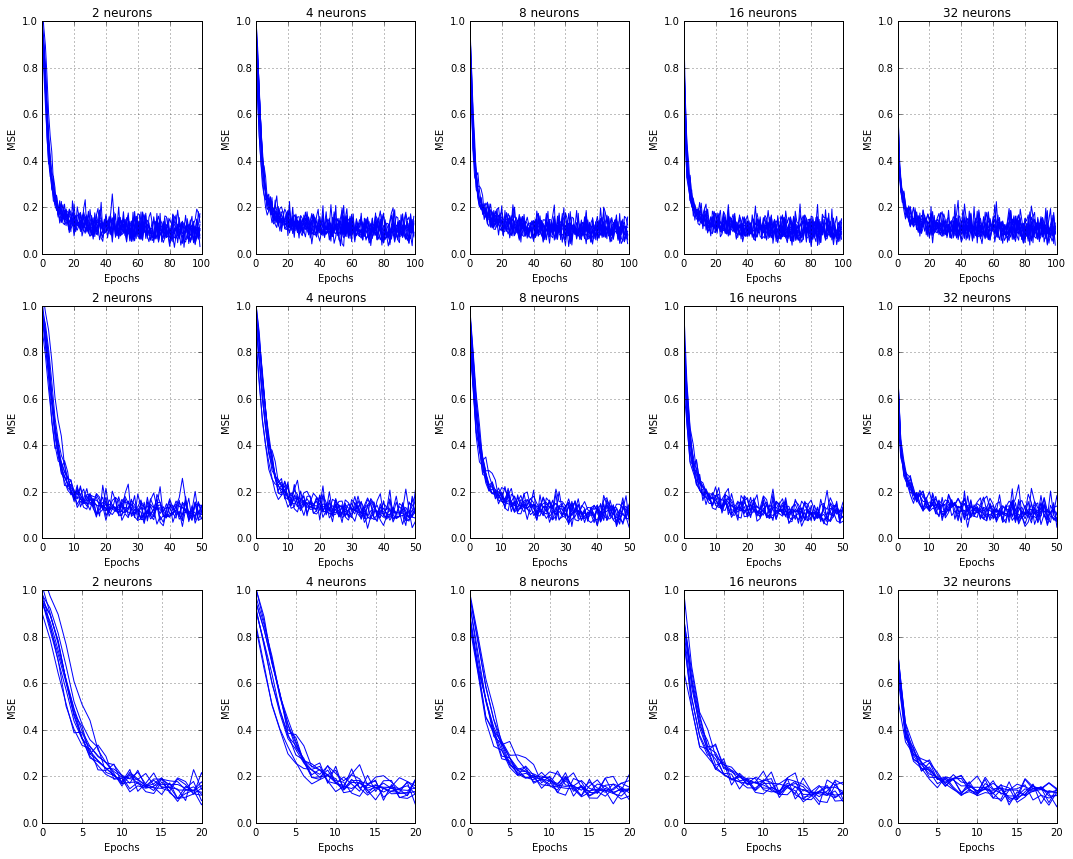

In [10]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

## Exploring the number of hidden neurons

In [11]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [12]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([2,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


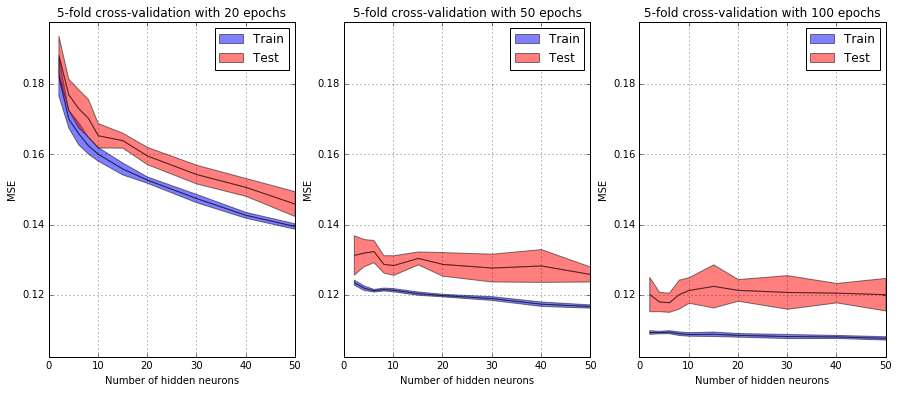

In [13]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

## Exploring the number of epochs and the number of hidden neurons at the same time


In [14]:
# maximum number of epochs
EPOCHS = 100
K = 5

In [15]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([2,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [16]:
min(np.min(MSE_train), np.min(MSE_test))

0.074920223470780839

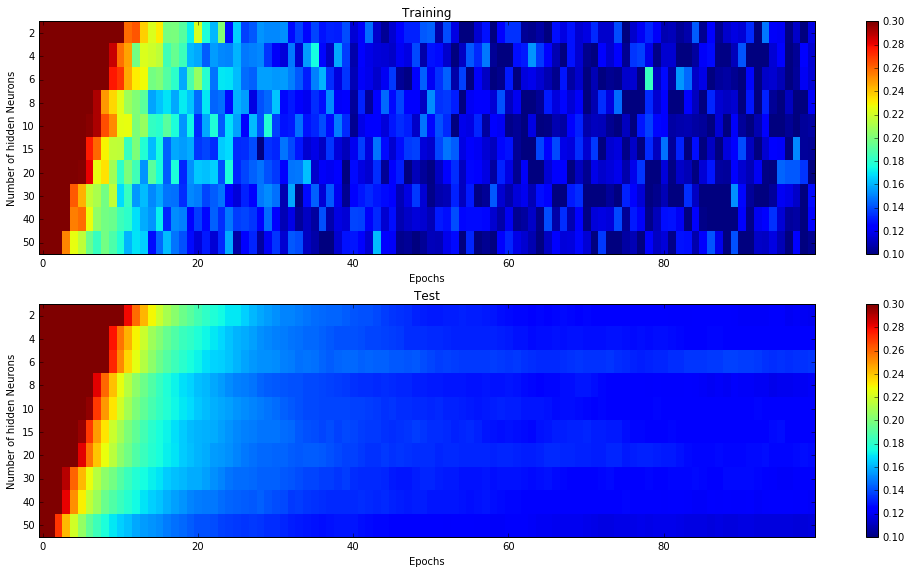

In [17]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 0.3

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

In [18]:
nn = mlp.MLP([2,2,1], 'tanh')

In [19]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [20]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.112526676167
MSE test:  0.120507266431
Confusion matrix:
[[ 97.   3.]
 [  3.  97.]]
